In [31]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Root directory of the project
ROOT_DIR = os.path.abspath("../../")

# Root directory to hdd
DATA_DIR = os.path.abspath("/data/hdd")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library

import mrcnn.model as modellib
from mrcnn import data_generator
from mrcnn import utils
from mrcnn import visualize
from mrcnn.model import log
from mrcnn.load_weights import load_weights

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(DATA_DIR, "russales", "test_logs")

# Local path to trained weights file
JUMP_MODEL_PATH = os.path.join(DATA_DIR, "russales", "logs", "jump20190413T1600", "mask_rcnn_jump_0160.h5")

## Notebook Preferences

In [32]:
# Device to load the neural network on.
# Useful if you're training a model on the same 
# machine, in which case use CPU and leave the
# GPU for training.
GPU_ID = "0"
DEVICE = "/gpu:{}".format(GPU_ID)  # /cpu:0 or /gpu:0

# Inspect the model in training or inference modes
# values: 'inference' or 'training'
# TODO: code for 'training' test mode not ready yet
TEST_MODE = "inference"
LIMIT = 0
EVAL_TYPE = "keypoints"
HEADS = "keypoint"

In [33]:
def get_ax(rows=1, cols=1, size=16):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Adjust the size attribute to control how big to render images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

## Configuration

In [34]:
import jump
class InferenceConfig(jump.JumpConfig):

    # Set batch size to 1 since we'll be running inference on
    # one image at a time. Batch size = GPU_COUNT * IMAGES_PER_GPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    DETECTION_MIN_CONFIDENCE = 0
    TRAINING_HEADS = HEADS


config = InferenceConfig()
config.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        25
DETECTION_MIN_CONFIDENCE       0
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
KEYPOINT_LOSS_WEIGHTING        True
KEYPOINT_MASK_POOL_SIZE        14
KEYPOINT_MASK_SHAPE            [56, 56]
KEYPOINT_THRESHOLD             0.005
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'mrcnn_mask_loss': 1.0, 'rpn

## Load Dataset

In [35]:
# Test dataset
JUMP_DIR = os.path.join(DATA_DIR, "russales", "JumpDataset", "mscoco_format")
dataset_test = jump.JumpDataset()
jump_dataset = dataset_test.load_jump(JUMP_DIR, "test", return_jump=True)
dataset_test.prepare()

print("Test Keypoints Image Count: {}".format(len(dataset_test.image_ids)))
print("Test Keypoints Class Count: {}".format(dataset_test.num_classes))
for i, info in enumerate(dataset_test.class_info):
    print("{:3}. {:50}".format(i, info['name']))

loading annotations into memory...
Done (t=0.03s)
creating index...
index created!
Skeleton: (0,)
Keypoint names: (20,)
Test Keypoints Image Count: 918
Test Keypoints Class Count: 2
  0. BG                                                
  1. person                                            


## Load Model

In [36]:
# Create model in inference mode
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = GPU_ID

with tf.device(DEVICE):
    model = modellib.MaskRCNN(mode=TEST_MODE, config=config, model_dir=MODEL_DIR)

# Load weights
print("Loading weights ", JUMP_MODEL_PATH)
load_weights(model, JUMP_MODEL_PATH, by_name=True, include_optimizer=False)

Loading weights  /data/hdd/russales/logs/jump20190413T1600/mask_rcnn_jump_0160.h5
Re-starting from epoch 160


## Evaluation

In [37]:
def build_jump_results(dataset, image_ids, result):
    # Arrange resutls to match COCO specs in http://cocodataset.org/#format
    # If no results, return an empty list

    if result["bboxes"] is None:
        return []

    rois = result["bboxes"]
    class_ids = result["class_ids"]
    scores = result["scores"]
    masks = None
    keypoints = None

    if "masks" in result:
        masks = result["masks"].astype(np.uint8)

    if "keypoints" in result:
        keypoints = result["keypoints"]

    results = []
    for image_id in image_ids:
        # Loop through detections
        for i in range(rois.shape[0]):
            class_id = class_ids[i]
            score = scores[i]
            bbox = np.around(rois[i], 1)

            result = {
                "image_id": image_id,
                "category_id": dataset.get_source_class_id(class_id, "jump"),
                "bbox": [bbox[1], bbox[0], bbox[3] - bbox[1], bbox[2] - bbox[0]],
                "score": score
            }

            if masks is not None:
                mask = masks[:, :, i]
                result["segmentation"] = maskUtils.encode(np.asfortranarray(mask))
            if keypoints is not None:
                keypoint = keypoints[i, :, :].flatten().tolist()
                result["keypoints"] = keypoint

            results.append(result)
    return results


def evaluate_jump(model, dataset, jump, eval_type="bbox", limit=0, image_ids=None, training_heads=None):
    """Runs a jump evaluation.

        model: MaskRCNN model for inference
        dataset: A Dataset object with valiadtion data
        jump: JUMP class to load annotations and result
        eval_type: 'segm', 'bbox' (official COCO evaluation) or 'keypoints' for jump evaluation
        limit: if not 0, it's the number of images to use for evaluation
    """

    # Pick image_ids from the dataset
    image_ids = image_ids or dataset.image_ids

    if eval_type == 'segm':
        # filter annotations for existing masks
        valid_ids = []
        for id in image_ids:
            _, _, mask_train = dataset.load_mask(id)
            if mask_train == 1:
                valid_ids.append(id)
        image_ids = valid_ids

    # Limit to a subset
    if limit and limit < len(image_ids):
        image_ids = image_ids[:limit]

    # Get corresponding COCO image IDs.
    jump_image_ids = [dataset.image_info[id]["id"] for id in image_ids]

    t_prediction = 0
    t_start = time.time()

    results = []
    total_image_count = len(image_ids)
    next_prgress = 0
    for i, image_id in enumerate(image_ids):
        # print progress
        progress = int(100 * (i / total_image_count))
        if next_prgress != progress:
            next_prgress = progress
            print('\r[{0}{1}] {2}%'.format('#' * progress, " " * (100 - progress), progress), end=' ', flush=True)

        # Load image
        image = dataset.load_image(image_id)

        # Run detection
        t = time.time()
        if training_heads == "keypoint":
            r = model.detect_keypoint([image], verbose=0)[0]
        elif training_heads == "mask":
            r = model.detect_mask([image], verbose=0)[0]
        else:
            r = model.detect([image], verbose=0)[0]

        t_prediction += (time.time() - t)

        # Convert results to COCO format
        # Cast masks to uint8 because COCO tools errors out on bool
        image_results = build_jump_results(dataset, jump_image_ids[i:i + 1], r)
        results.extend(image_results)

    print("")
    if training_heads == "mask":

        results = [i for i in results if i['segmentation']['counts'] != bytes(b'PPYo1')]
        if results:
            # Load results. This modifies results with additional attributes.
            jump_results = jump.loadRes(results)

            # Evaluate
            from pycocotools.cocoeval import COCOeval
            cocoEval = COCOeval(cocoGt=jump, cocoDt=jump_results, iouType=eval_type)
            cocoEval.params.imgIds = jump_image_ids
            cocoEval.evaluate()
            cocoEval.accumulate()
            cocoEval.summarize()

    if training_heads == "keypoint":
        import samples.jump.pose_metrics
        from samples.jump.bisp_joint_order import JumpJointOrder

        predictions = []
        annotations = []
        for result in results:
            predictions.append(samples.jump.pose_metrics.np.array(result["keypoints"]).reshape((1, 20, 3)))
            annotations.append(samples.jump.pose_metrics.np.array(
                [i for i in dataset.image_info if i['id'] == result['image_id']][0]["annotations"][0][
                    "keypoints"]).reshape((1, 20, 3)))

        norm_distance = samples.jump.pose_metrics.pck_normalized_distances_fast(np.asarray(predictions).squeeze(),
                                                                                np.asarray(annotations).squeeze(),
                                                                                ref_length_indices=(
                                                                                    JumpJointOrder.l_shoulder,
                                                                                    JumpJointOrder.r_hip))
        # filter norm_distance for invalid flags
        norm_distance = np.where(norm_distance > 0, norm_distance, -1)

        # plot
        pck_thresholds, pck_scores = samples.jump.pose_metrics.pck_scores_from_normalized_distances(norm_distance)

        import matplotlib.pyplot as plt
        plt.plot(pck_thresholds, pck_scores)
        plt.xlabel('PCK thresholds')
        plt.ylabel('PCK scores')
        plt.axis([0, pck_thresholds.max(), 0, pck_scores.max()])
        plt.show()

        score = samples.jump.pose_metrics.pck_score_at_threshold(pck_thresholds, pck_scores, 0.2)
        print("Avg. PCK {}".format(score))

    print("----------------------------------")
    print("Prediction time: {}. Average {}/image".format(t_prediction, t_prediction / len(image_ids)))
    print("Total time: ", time.time() - t_start)


[################################################################################################### ] 99% 


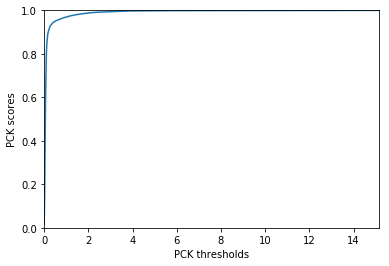

Avg. PCK 0.9052319309600863
----------------------------------
Prediction time: 293.83032298088074. Average 0.32007660455433634/image
Total time:  389.1849241256714


In [38]:
 evaluate_jump(model, dataset_test, jump_dataset, EVAL_TYPE, limit=LIMIT, training_heads=HEADS)